In [1]:
%load_ext autoreload
%autoreload 2


# Load model and data

In [2]:
from symbxai.lrp.symbolic_xai import BERTSymbXAI
from symbxai.model.transformer import bert_base_uncased_model
from symbxai.dataset.utils import load_sst_treebank, load_imdb_dataset
import transformers
import pickle
model = bert_base_uncased_model(
            pretrained_model_name_or_path='textattack/bert-base-uncased-SST-2' )
    
model.eval()
# pretrained_embeddings = model.bert.embeddings
tokenizer = transformers.BertTokenizer.from_pretrained("textattack/bert-base-uncased-SST-2")
sample_range = map(int, '138 259 324 385 413 658 851 1469 1518 1614 1716 2086 2351 2509 2555 3287 3423 3427 3493 3617 4328 4634 4724 5177 5293 5356 5602 5703 5734 6072 6347 6593 7147 7349 7411 7560 8015 8145'.split(' '))
sst_dataset = load_sst_treebank(sample_range, verbose=False)['train']
with open('../data/mouth_segments.json', 'rb') as file:
    mouth_segments = pickle.load(file)
with open('../data/eyes_segments.json', 'rb') as file:
    eyes_segments = pickle.load(file)

# print('got', len(dataset['label']), 'samples from sst')

dataset = {'sentence': { 0: "Not very good" }, 'label': {0:0} }

for sentence in sst_dataset['sentence'].values():
    print(sentence, '\n')


/opt/homebrew/Caskroom/miniconda/base/envs/symbxai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


it's tough to watch, but it's a fantastic movie. 

s1m0ne's satire is not subtle, but it is effective. 

this orange has some juice, but it's far from fresh-squeezed. 

strange it is, but delightfully so. 

i 've never bought from telemarketers, but i bought this movie. 

it's still a comic book, but maguire makes it a comic book with soul. 

could use a little more humanity, but it never lacks in eye-popping visuals. 

the movie is amateurish, but it's a minor treat. 

topics that could make a sailor blush - but lots of laughs. 

the picture runs a mere 84 minutes, but it's no glance. 

it doesn't reach them, but the effort is gratefully received. 

a modestly made but profoundly moving documentary. 

me no lika da accents so good, but i thoroughly enjoyed the love story. 

a summer entertainment adults can see without feeling embarrassed, but it could have been more. 

the sentimental script has problems, but the actors pick up the slack. 

it's never laugh-out-loud funny, but it is 

# Setup explainer

In [3]:
import torch

sentence, label = dataset['sentence'][0],  dataset['label'][0]
sample = tokenizer(sentence, return_tensors="pt")
tokens = tokenizer.convert_ids_to_tokens(sample['input_ids'].squeeze())
target_class = model(**sample)['logits'].argmax().item()
print(sentence)
print('prediction is', target_class)
# output_mask = torch.tensor([0,0]); output_mask[target_class]=1
output_mask = torch.tensor([0,0])
output_mask[label] =1 

### Generate node ordering
explainer = BERTSymbXAI(sample=sample,
                    target=output_mask,
                    model=model,
                    embeddings=model.bert.embeddings,
                    gam=.01
                       )

token2id = {token: i for i,token in enumerate(tokens)}
neg_tokens = ['[CLS]', '[SEP]']
interesting_tokens = list(range(1,len(tokens)-1)) #[token for token in tokens if token not in neg_tokens]


Not very good
prediction is 0


100%|██████████| 7/7 [00:01<00:00,  6.86it/s]


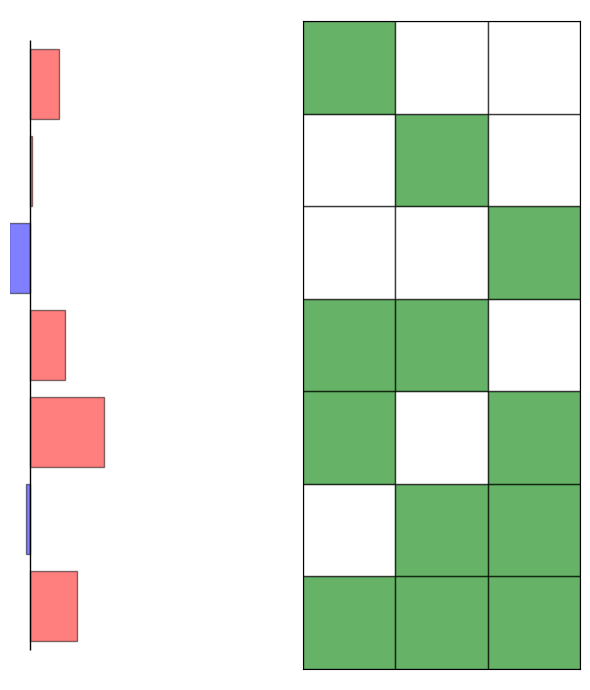

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from tqdm import tqdm

def generate_table(tokens, max_subsetsize = 4):
    N = len(tokens)
    # num_subsets = 2 ** N

    # Generate all subsets of tokens
    subsets = list(itertools.chain.from_iterable(itertools.combinations(tokens, r) for r in range(N+1)))[::-1]
    subsets = [sset for sset in subsets if sset != () and len(sset)<=max_subsetsize]
    # Create a matrix to represent the table
    table = np.zeros((len(subsets), N))

    for j, subset in enumerate(subsets):
        for token in subset:
            i = tokens.index(token)
            table[j, i] = 1

    return table, subsets

# def generate_values(num_subsets):
#     # Generate random values from a normal distribution
#     values = np.random.randn(num_subsets)
#     return values

def plot_table(table, subsets, tokens, values):
    num_subsets, N = table.shape

    fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1]}, figsize=(len(tokens)*2, len(subsets)))

    # Plot histograms
    for j in range(num_subsets):
        value = values[j]
        color = 'red' if value >= 0 else 'blue'
        ax[0].barh(j, value, color=color, edgecolor='black', alpha=.5)


    ax[0].set_xlim(-0.5, num_subsets - 0.5)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    # Set the bottom and top spines invisible
    ax[0].spines['bottom'].set_visible(False)
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['left'].set_visible(False)
    # Set the Y-axis tick label font size
    ax[0].tick_params(axis='y', labelsize=20)

    # draw horizontal line
    ax[0].vlines(0, -0.5, num_subsets - 0.5, colors='black', lw=1)

    # Plot the table
    for i in range(N):
        for j in range(num_subsets):
            color = 'green' if table[j, i] == 1 else 'white'
            rect = plt.Rectangle([i, j],1,  1, facecolor=color, edgecolor='black', alpha=.6)
            ax[1].add_patch(rect)

    # Set the x and y ticks
    ax[1].set_yticks([])
    ax[1].set_xticks([])
    # ax[1].set_xticklabels([str(set(subset)) for subset in subsets], rotation=90)
    # ax[1].set_xticklabels(tokens[::-1], fontsize=20)

    # Set the limits and aspect ratio
    ax[1].set_ylim(0, num_subsets)
    ax[1].set_xlim(0, N)
    ax[1].set_aspect('equal')

    plt.tight_layout()
    # plt.savefig('intermediate_results/fig1_multi_order_subsets.svg', transparent=True)
    plt.show()

# Example usage
# tokens = ['Not', 'very', 'good',]
table, subsets = generate_table(interesting_tokens)
values = {}
for subset in tqdm(subsets):
    values[subset] = explainer.harsanyi_div([tid for tid in subset])
# values = {subset:  for subset in subsets }
plot_table(table, subsets, interesting_tokens, list(values.values()))

# Show first order XAI

In [5]:
from IPython.display import display, HTML, Latex
from symbxai.visualization.utils import html_heatmap 
from html2image import Html2Image

html_str = html_heatmap(tokens[1:-1], explainer.node_relevance()[1:-1] ) 

htmlimg = Html2Image()
htmlimg.output_path= 'intermediate_results/'
htmlimg.screenshot(
    html_str=html_str,
    css_str ='',
    save_as ='temp_sentence.png',
    size    =(len(tokens)* 40,50)
            )

display(HTML(html_str))

2475 bytes written to file /Users/thomasschnake/Research/Projects/symbolic_xai_cleaned/symbolicXAI_github/notebooks/intermediate_results/temp_sentence.png


# Set up queries

In [6]:
from symbxai.utils import Query
symbxai_mode = True

if symbxai_mode:
    queries_ids = [ ('$\\neg$not $\\wedge$good', ((1 - len(tokens),), (3,))),
              ('not$\\wedge$good', ((1,),(3,))),
              ('not $\\wedge \\neg$good', ((1,), (3-len(tokens),),))]
    image_name = 'fig1_query_attr_barplot'
else:
    queries_ids = [ ('not', ((1,),)),
              ('very', ((2,),)),
              ('good', ((3,),))]
    image_name = 'fig1_word_attr_barplot'
queries = [Query(str_rep=str_rep, hash_rep=hash_rep, nb_feats=len(tokens)) for str_rep, hash_rep in queries_ids ]

# Generate binary vector for the filter function

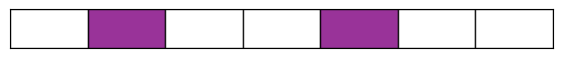

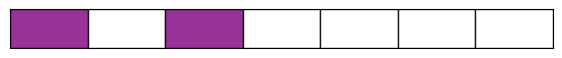

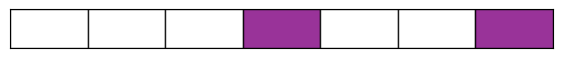

In [7]:

for qid, query in enumerate(queries):
    fig, ax = plt.subplots(figsize=(len(subsets),1))
    bin_table = np.array([int(query(tuple([tid for tid in subset]) )) for subset in subsets])

    for j in range(len(subsets)):
        color = 'purple' if bin_table[j] == 1 else 'white'
        rect = plt.Rectangle([j, 0], 1, .5, facecolor=color, edgecolor='black', alpha=.8)
        ax.add_patch(rect)
    
    # Set the x and y ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Set the limits and aspect ratio
    ax.set_xlim(0, len(subsets))
    ax.set_ylim(0, .5)
    ax.set_aspect('equal')
    plt.savefig(f'intermediate_results/fig1_query_subset{qid}.png', transparent=True)

# Calculate query attribution

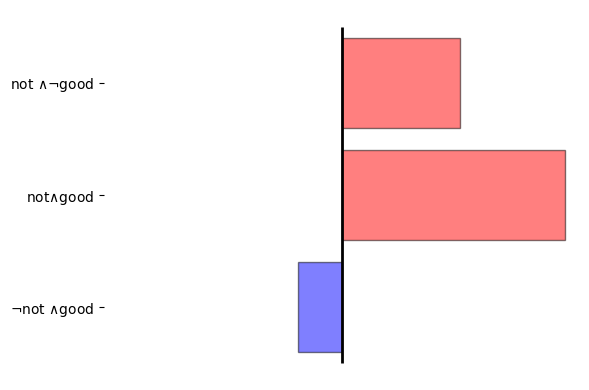

In [8]:

fig, ax = plt.subplots(figsize=(6,4))
for query in queries:
    # display(Latex(query.str_rep))
    query.attribution = sum([ values[subset].item() for subset in subsets if query(tuple([tid for tid in subset]) )])
    
    plt.barh(query.str_rep, query.attribution, color='red' if query.attribution>0 else 'blue', edgecolor='black', alpha=.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.xticks([])

plt.vlines(0, -.5, len(queries)-.5, color='black', lw=2)
maxval= max([abs(q.attribution) for q in queries ])
plt.xlim(-maxval -.2, maxval+.2)
plt.tight_layout()
plt.savefig(f'intermediate_results/{image_name}.svg', transparent=True)

# Calculate first-order histogram

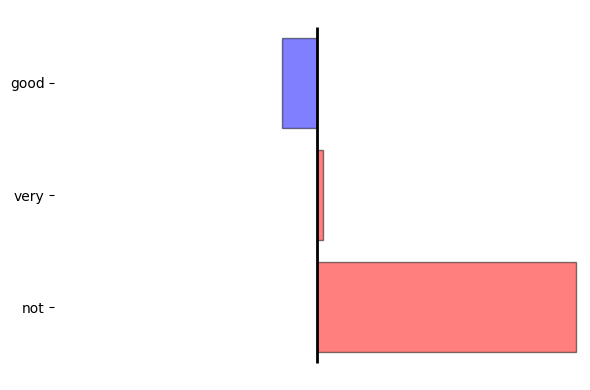

In [9]:
fig, ax = plt.subplots(figsize=(6,4))

token_rels = explainer.node_relevance()[1:-1]

for rel, token in zip(token_rels, ['not', 'very',  'good']):
    
    plt.barh(token, rel, color='red' if rel>0 else 'blue', edgecolor='black', alpha=.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.xticks([])

plt.vlines(0, -.5, len(queries)-.5, color='black', lw=2)
maxval= max(token_rels)
plt.xlim(-maxval -.2, maxval+.2)
plt.tight_layout()
plt.savefig('intermediate_results/fig1_word_attr_barplot.svg', transparent=True)

# Calculate query expressiveness

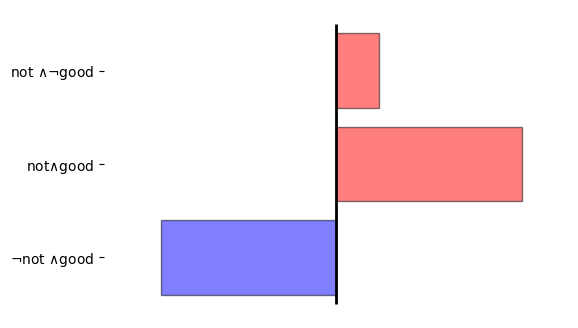

In [10]:
from symbxai.query_search.utils import corr
fig, ax = plt.subplots(figsize=(6,4))

for query in queries:
    # display(Latex(query.str_rep))
    qvec, harsdiv, eta = zip(*[( int(query(tuple([tid for tid in subset]) )), val.item(), 1) for subset, val in values.items()])
    qvec, harsdiv, eta = map(np.array, [qvec, harsdiv, eta])
    # print(qvec,'\n',harsdiv)
    query.attribution = corr(qvec,harsdiv,eta)
    
    plt.barh(query.str_rep, query.attribution, color='red' if query.attribution>0 else 'blue', edgecolor='black', alpha=.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.xticks([])

plt.vlines(0, -.5, len(queries)-.5, color='black', lw=2)
maxval= max([abs(q.attribution) for q in queries ])
plt.xlim(-maxval -.2, maxval+.2)
plt.savefig('intermediate_results/fig1_query_expressiv_barplot.png', transparent=True)

# Search Queries

In [11]:
from symbxai.query_search.utils import setup_queries
max_and_order = 4
all_queries = setup_queries(explainer.node_domain, 
                                    tokens,
                                    max_and_order, 
                                    # max_setsize=max_setsize, 
                                    # max_indexdist=1, 
                                    # mode=query_mode,
                                    neg_tokens=[0,len(tokens) -1 ])

for i, q in enumerate(all_queries):
    # featsset = queryhash2featset(q.hash, tokens)
    qvec, harsdiv, eta = zip(*[( int(q(tuple([tid for tid in subset]) )), val.item(), 1) for subset, val in values.items()])
    qvec, harsdiv, eta = map(np.array, [qvec, harsdiv, eta])
    
    # print(qvec,'\n',harsdiv)
    q.expressiveness = corr(qvec,harsdiv,eta)
    q.attribution = sum([ values[subset].item() for subset in subsets if q(tuple([tid for tid in subset]) )])
    
    # display(HTML(f'('+ q.str_rep + f')<br> {round(q.attribution,3)} - {round(q.expressiveness,3)}<br><br>'))

In [12]:
queries_most_attr = sorted(all_queries, key = lambda q: q.attribution, reverse=True)

for i, q in enumerate(queries_most_attr[:10]):
    display(HTML( f'{i+1}.) '+ q.str_rep + f'  --> {round(q.attribution,3)}'))

In [13]:
queries_most_expr = sorted(all_queries, key = lambda q: q.expressiveness, reverse=True)
for i,q in enumerate(queries_most_expr[:10]):
    display(HTML(f'{i+1}.) '+ q.str_rep + f'  --> {round(q.expressiveness,3)}'))